In [102]:
import networkx as nx
import numpy as np
import copy
import time
import matplotlib.pyplot as plt # https://matplotlib.org/stable/plot_types/basic/plot.html


def get_net(net_type, net_order, rng=None):
    if net_type == 'scale_free':
        return nx.barabasi_albert_graph(n=net_order, m=2, seed=rng, initial_graph=nx.complete_graph(3))

    elif net_type == 'complete_mixing':
        return nx.complete_graph(n=net_order)

    elif net_type == 'lattice':
        return nx.grid_2d_graph(int(np.sqrt(net_order)), int(np.sqrt(net_order)), periodic=False)

    else:
        return None
    

def opinion_diff(u, v, G):
    return G.nodes[u]['opinion'] - G.nodes[v]['opinion']


def update_opinions(u, v, G, convergence, symmetric_updating=True):
    diff = opinion_diff(u, v, G)

    G.nodes[u]['opinion'] -= convergence * diff
    
    if symmetric_updating:
        G.nodes[v]['opinion'] += convergence * diff
    return G

        
def update_effective_net(u, v, effective_net, G, threshold, symmetric_updating):
    # update u's neighbors
    for w in G.neighbors(u):
        diff = abs(opinion_diff(u, w, G))
        
        if diff <= threshold and not effective_net.has_edge(u, w):
            effective_net.add_edge(u, w)

        elif diff > threshold and effective_net.has_edge(u, w):
            effective_net.remove_edge(u, w)
        
    if not symmetric_updating:
        return effective_net
    
    # update v's neighbors
    for w in G.neighbors(v):
        diff = abs(opinion_diff(u, w, G))
        
        if diff <= threshold and not effective_net.has_edge(v, w):
            effective_net.add_edge(v, w)

        elif diff > threshold and effective_net.has_edge(v, w):
            effective_net.remove_edge(v, w)
    return effective_net


def simulate_deffuant_model(G: nx.Graph, iterations: int, threshold: float, convergence: float,\
                            symmetric_updating=True, fast_mode=False, rng=np.random.default_rng(42)):
    """
    Simulates the Deffuant model on the given graph.

    Parameters
    ----------
    G : networkx.Graph
        The graph on which to simulate the model.
    iterations : int
        The number of iterations to run the simulation for.
    threshold : float
        Threshold value for node interaction in the model.
    convergence : float
        The value used for updating opinions in the model.
    symmetric_updating: bool
        If True, at every timestep both nodes update their opinions.
        If False, at every timestep only the first selected node updates its opinion.
    fast_mode: bool
        If True, only the last effective network is returned and used throughout the simulation.
        If False, every effective network is saved and returned.

    Returns
    -------
    list[networkx.Graph]
        A list of graphs, where each graph represents the state of the network at a given time step.
    """
    
    # initialize node attributes
    for node in G.nodes():
        G.nodes[node]['opinion'] = rng.random()

    # get initial effective network
    effective_net = copy.deepcopy(G)
    
    # remove edges between nodes with opinion difference above threshold
    for u, v in effective_net.edges:
        if abs(opinion_diff(u, v, G)) > threshold:
            effective_net.remove_edge(u, v)

    if not fast_mode:
        # initialize the list of nets that will be returned
        effective_networks = [effective_net]

    # run simulation
    for t in range(1, iterations):
        
        if not fast_mode:
            # copy last effective network
            effective_net = copy.deepcopy(effective_networks[t-1])
        
        # choose random node to update
        u = rng.choice(G.order())
        
        # get another node if u is isolated
        while not list(effective_net.neighbors(u)):
            u = rng.choice(G.order())
        
        # get a random neighbor of u
        v = rng.choice(list(effective_net.neighbors(u)))

        # update their opinions
        G = update_opinions(u, v, G, convergence, symmetric_updating)
        
        # we now update the connections of these nodes in the effective network depending on
        # the opinions of their neighbors in the underlying network G
        effective_net = update_effective_net(u, v, effective_net, G, threshold, symmetric_updating)
        
        if not fast_mode:
            # add it to list
            effective_networks.append(effective_net)
    
    if not fast_mode:
        return effective_networks
    else:
        return effective_net

In [103]:
# METRIC/PLOT FUNCTIONS

# equation 3 in the paper
def dispersion_index(G):
    return sum([len(cluster)**2 for cluster in nx.connected_components(G)])/(G.order()**2)


# computes the avg value of a metric over a range of d values in a given net type and fixed convergence
def metric_d_plot_data(metric, net_type, net_order, iterations, sample_size, num_points, init_d, final_d, convergence, rng):
    # initialize vector with data
    metric_avgs = np.zeros(num_points)
    # initialize vector with x-axis points
    d = [init_d + i*(final_d-init_d)/num_points for i in range(num_points)]
    
    for i in range(num_points):
        print(".", end='') # loading
        
        # at every point we will average the metric over sample_size networks
        for j in range(sample_size):
            
            # generate network sample
            initial_net = get_net(net_type, net_order, rng)

            final_net = simulate_deffuant_model(initial_net, iterations, d[i], convergence, fast_mode=True, rng=rng)
            
            # add metric to data vect so that we can compute the avg
            metric_avgs[i] += metric(final_net)
    
    print()
    # compute avgs
    metric_avgs = metric_avgs/sample_size

    return d, metric_avgs


# computes the avg evolution of a metric in the deffuant model with fixed parameters in a given net type and fixed convergence
def metric_evol_plot_data(metric, net_type, net_order, iterations, sample_size, d, convergence, rng):
    # initialize vector with data
    metric_avgs = np.zeros(iterations)
    
    for i in range(sample_size):
        print(".", end='') # loading
        
        # generate network sample
        initial_net = get_net(net_type, net_order, rng)

        nets = simulate_deffuant_model(initial_net, iterations, d, convergence, fast_mode=False, rng=rng)

        # add metric of every net so that we can compute the avg
        metric_avgs = metric_avgs + np.array([metric(net) for net in nets])
    
    print()
    # compute avgs
    metric_avgs = metric_avgs/sample_size

    return list(range(iterations)), metric_avgs
   

# runs simulation and sets x and y with the initial and final opinions of agents
def opinion_change_plot_data(network, iterations, d, convergence, rng):    
    final_network = simulate_deffuant_model(network, iterations, d, convergence, fast_mode=True, rng=rng)
    
    x = [network.nodes[node]['opinion'] for node in network.nodes()]
    y = [final_network.nodes[node]['opinion'] for node in final_network.nodes()]
    y_bar = np.array([network.degree[node] for node in network.nodes()])
    
    # rescale the bars
    y_bar = y_bar/(4*max(y_bar))
    
    return x, y, y_bar

...............


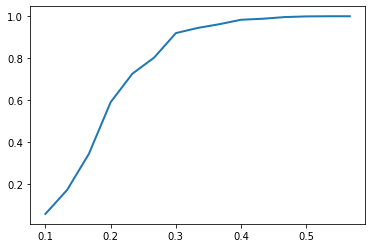

In [105]:
# PLOT METRIC AT DIFFERENT VALUES OF D

rng = np.random.default_rng(42)

x, y = metric_d_plot_data(metric=dispersion_index, net_type='scale_free', net_order=500, iterations=10000,\
                            sample_size=5, num_points=15, init_d=0.1, final_d=0.6, convergence=0.3, rng=rng)

fig, ax = plt.subplots()
ax.plot(x, y, linewidth=2.0)

plt.show()

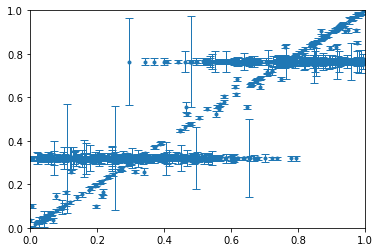

In [99]:
# OPINION CHANGE PLOT (requires many iterations)

rng = np.random.default_rng(42)

net = nx.barabasi_albert_graph(n=900, m=2, seed=rng, initial_graph=nx.complete_graph(3))

x, y, y_bar = opinion_change_plot_data(network=net, iterations=400000, d=0.2, convergence=0.3, rng=rng)

fig, ax = plt.subplots()
ax.errorbar(y, x, y_bar, fmt='.', linewidth=1, capsize=4)

ax.set(xlim=(0, 1), ylim=(0, 1))

plt.show()

In [4]:
# we set n=900 in the BA graph so that it has the same amount of vertices as the 30x30 grid graph
# we set m=2 so that the average degree of the graph is 2*|E|/n = 2*(3+2*897)/900 ~= 4 as in the grid graph

BA_graph = nx.barabasi_albert_graph(n=900, m=2, seed=42, initial_graph=nx.complete_graph(3))
lattice  = nx.grid_2d_graph(30, 30, periodic=False, create_using=None)

In [7]:
start = time.time()

effective_networks = simulate_deffuant_model(BA_graph, 1000, 0.3, 0.3, fast_mode=True)

total_time = round(time.time()-start, 3)
print(f"simulation time: {total_time} seconds")

simulation time: 0.16 seconds


In [6]:
#nx.draw(res[-1], nx.spring_layout(res[-1]))

In [4]:
print(nx.__version__)

2.8.8


In [45]:
G = nx.Graph()
G.add_edge(1,2)

G.nodes[1]['a'] = 42
print(G.nodes[1]['a'])

def change(n, key, val, G):
    G.nodes[n][key] = val
    
change(1,'a', 43, G)

print(G.nodes[1]['a'])

42
43
